In [234]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [235]:
batch_size = 64
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [236]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [237]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model jest klasyczną konwolucyjną siecią neuronową do rozpoznawania obrazów. FashionMNIST to 28×28 szare obrazy przedstawiające elementy odzieży — zadaniem sieci jest zaklasyfikowanie ich do jednej z 10 klas (np. T-shirt, Sneaker, Bag itd.).

In [238]:
# Definicja CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.dropout = nn.Dropout(0.3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 10)  # 10 klas

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [batch, 32, 13, 13]
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))  # -> [batch, 64, 5, 5]
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

In [239]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ewaluacja na zbiorze testowym
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Epoch 1/10 | Train Loss: 0.5323 | Train Acc: 0.8081 | Test Loss: 0.3782 | Test Acc: 0.8645
Epoch 2/10 | Train Loss: 0.3478 | Train Acc: 0.8738 | Test Loss: 0.3144 | Test Acc: 0.8891
Epoch 3/10 | Train Loss: 0.2993 | Train Acc: 0.8921 | Test Loss: 0.2878 | Test Acc: 0.8971
Epoch 4/10 | Train Loss: 0.2735 | Train Acc: 0.9000 | Test Loss: 0.2821 | Test Acc: 0.8970
Epoch 5/10 | Train Loss: 0.2539 | Train Acc: 0.9067 | Test Loss: 0.2822 | Test Acc: 0.8953
Epoch 6/10 | Train Loss: 0.2375 | Train Acc: 0.9121 | Test Loss: 0.2586 | Test Acc: 0.9065
Epoch 7/10 | Train Loss: 0.2246 | Train Acc: 0.9162 | Test Loss: 0.2581 | Test Acc: 0.9064
Epoch 8/10 | Train Loss: 0.2142 | Train Acc: 0.9197 | Test Loss: 0.2433 | Test Acc: 0.9125
Epoch 9/10 | Train Loss: 0.2051 | Train Acc: 0.9228 | Test Loss: 0.2392 | Test Acc: 0.9139
Epoch 10/10 | Train Loss: 0.1943 | Train Acc: 0.9268 | Test Loss: 0.2392 | Test Acc: 0.9135


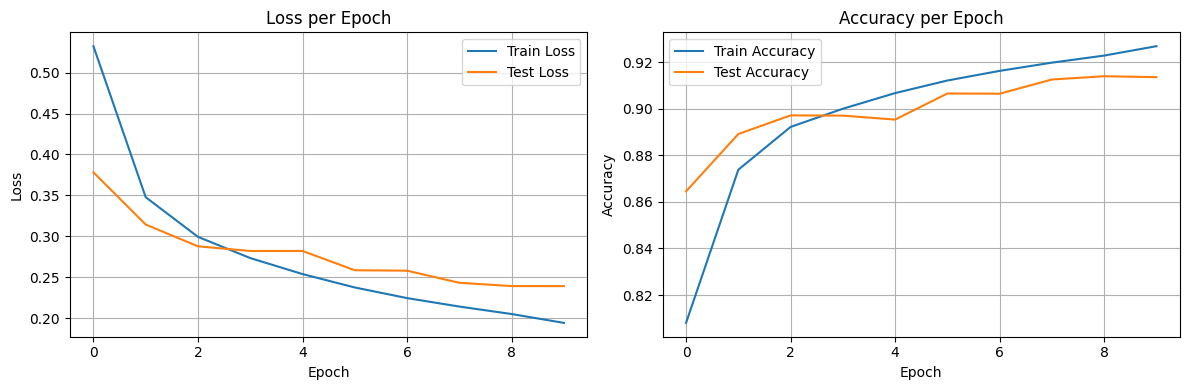

In [240]:
import matplotlib.pyplot as plt

# Wykres strat
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [241]:
import numpy as np
import random

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

model.eval()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

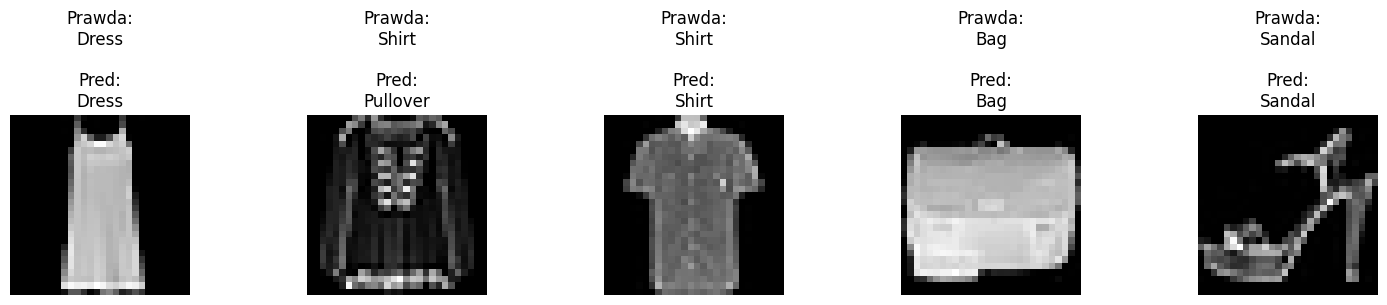

In [242]:
indices = random.sample(range(len(test_dataset)), 5)
# Tworzenie wykresu
plt.figure(figsize=(15, 3))

for i, idx in enumerate(indices):
    image, label = test_dataset[idx]
    input_image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_image)
        pred = output.argmax(dim=1).item()

    # Rysowanie obrazka
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Prawda:\n{class_names[label]}\n\nPred:\n{class_names[pred]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Metryki

In [243]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns

In [244]:
import numpy as np

model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        preds = outputs.argmax(dim=1) #  best prediction
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Konwersja do numpy
all_preds = np.array(all_preds) # predykcje
all_labels = np.array(all_labels) # prawdziwe etykiety
all_probs = np.array(all_probs) # prawdopodobieństwa

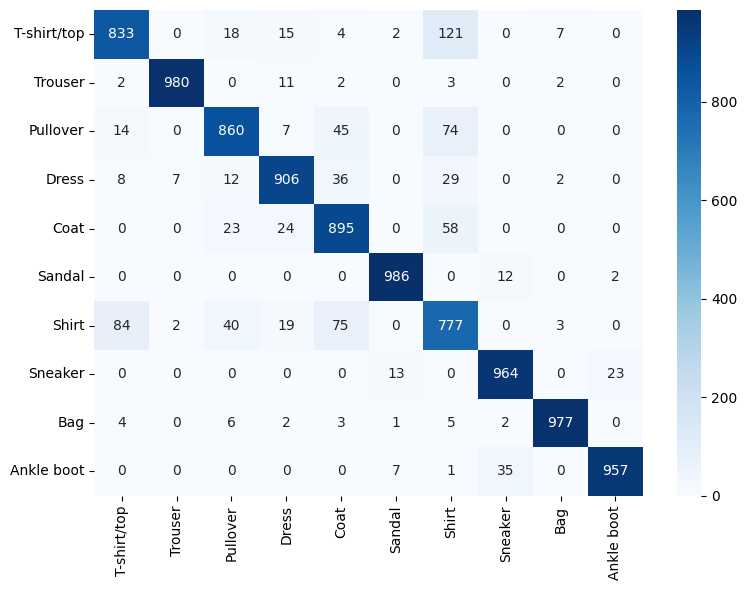

In [245]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.savefig('CNN_matrix.png', dpi=300)

plt.show()


In [246]:
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9135


In [247]:
from sklearn.preprocessing import label_binarize

labels_bin = label_binarize(all_labels, classes=range(10)) # binarization for ROC AUC

roc_auc = roc_auc_score(labels_bin, all_probs, average=None) # 

for i, auc_val in enumerate(roc_auc):
    print(f"ROC AUC dla klasy {class_names[i]}: {auc_val:.4f}")

ROC AUC dla klasy T-shirt/top: 0.9920
ROC AUC dla klasy Trouser: 0.9996
ROC AUC dla klasy Pullover: 0.9920
ROC AUC dla klasy Dress: 0.9968
ROC AUC dla klasy Coat: 0.9934
ROC AUC dla klasy Sandal: 0.9998
ROC AUC dla klasy Shirt: 0.9756
ROC AUC dla klasy Sneaker: 0.9992
ROC AUC dla klasy Bag: 0.9991
ROC AUC dla klasy Ankle boot: 0.9992


In [248]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(all_labels, all_preds)
print(f"MSE (Mean Squared Error): {mse:.4f}")

MSE (Mean Squared Error): 1.2879


Krzywe ROC "One-vs-Rest" (OvR) 

Dla każdej klasy:

-traktujemy ją jako "pozytywną" klasę,

-a wszystkie pozostałe klasy jako "negatywne",

In [249]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [250]:
def get_probs_and_labels(dataloader):
    all_probs = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

# Pobierz dane z train i test
train_probs, train_labels = get_probs_and_labels(train_loader)
test_probs, test_labels = get_probs_and_labels(test_loader)

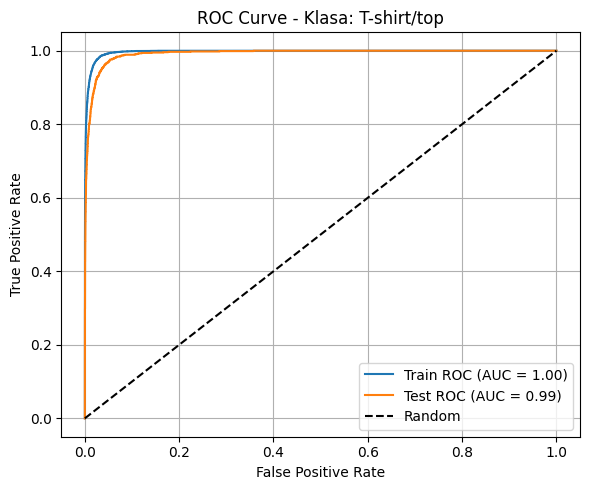

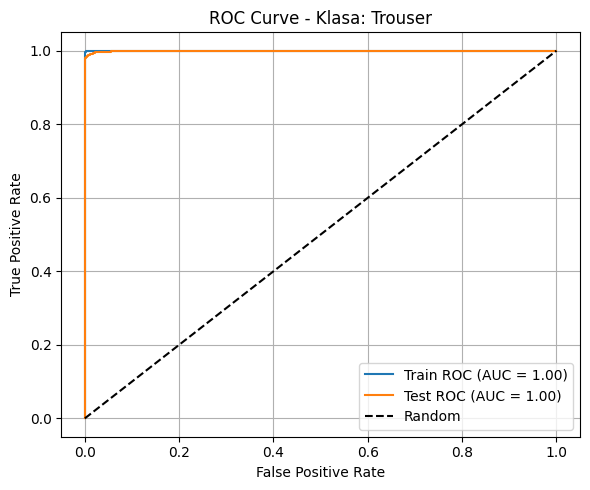

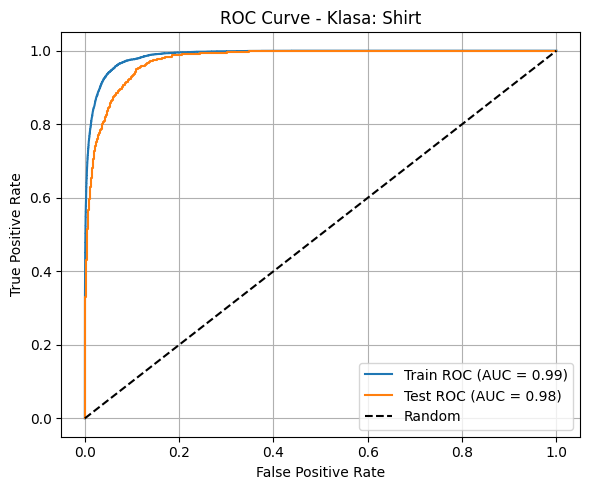

In [251]:
from sklearn.preprocessing import label_binarize

train_labels_bin = label_binarize(train_labels, classes=range(10))
test_labels_bin = label_binarize(test_labels, classes=range(10))

n_classes = 10
classes_to_plot = [0, 1, 6]  # np. T-shirt/top, Trouser, Shirt

for i in classes_to_plot:
    fpr_train, tpr_train, _ = roc_curve(train_labels_bin[:, i], train_probs[:, i])
    fpr_test, tpr_test, _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.2f})")
    plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - Klasa: {class_names[i]}")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

LSTM

In [252]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.dropout = nn.Dropout(0.3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)

        # LSTM
        self.lstm_input_size = 64  # liczba cech na krok
        self.sequence_length = 25

        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=64,
                            batch_first=True, num_layers=1)

        # Fully connected layer
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # [B, 32, 13, 13]
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))   # [B, 64, 5, 5]

        x = x.view(x.size(0), 64, 25)          # [B, 64, 25]
        x = x.permute(0, 2, 1)                 # [B, 25, 64]

        # LSTM
        out, _ = self.lstm(x)                  # [B, 25, 64]
        out = out[:, -1, :]

        # Klasyfikacja
        out = self.fc(out)                     # [B, 10]
        return out

In [253]:
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [254]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ewaluacja na zbiorze testowym
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Epoch 1/10 | Train Loss: 0.7853 | Train Acc: 0.7143 | Test Loss: 0.5889 | Test Acc: 0.7852
Epoch 2/10 | Train Loss: 0.4898 | Train Acc: 0.8212 | Test Loss: 0.4453 | Test Acc: 0.8400
Epoch 3/10 | Train Loss: 0.4102 | Train Acc: 0.8510 | Test Loss: 0.3931 | Test Acc: 0.8599
Epoch 4/10 | Train Loss: 0.3596 | Train Acc: 0.8690 | Test Loss: 0.3560 | Test Acc: 0.8721
Epoch 5/10 | Train Loss: 0.3282 | Train Acc: 0.8814 | Test Loss: 0.3390 | Test Acc: 0.8804
Epoch 6/10 | Train Loss: 0.3063 | Train Acc: 0.8890 | Test Loss: 0.3354 | Test Acc: 0.8793
Epoch 7/10 | Train Loss: 0.2894 | Train Acc: 0.8952 | Test Loss: 0.3119 | Test Acc: 0.8881
Epoch 8/10 | Train Loss: 0.2753 | Train Acc: 0.8998 | Test Loss: 0.3134 | Test Acc: 0.8871
Epoch 9/10 | Train Loss: 0.2634 | Train Acc: 0.9043 | Test Loss: 0.2806 | Test Acc: 0.9007
Epoch 10/10 | Train Loss: 0.2525 | Train Acc: 0.9070 | Test Loss: 0.2849 | Test Acc: 0.8997


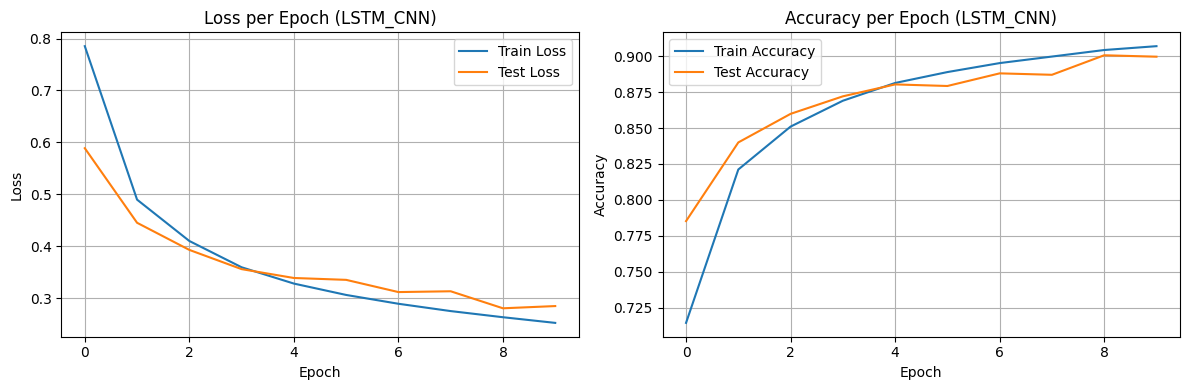

In [255]:
# Tworzymy dwa wykresy obok siebie
plt.figure(figsize=(12, 4))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss per Epoch (LSTM_CNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title("Accuracy per Epoch (LSTM_CNN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [264]:
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.8997


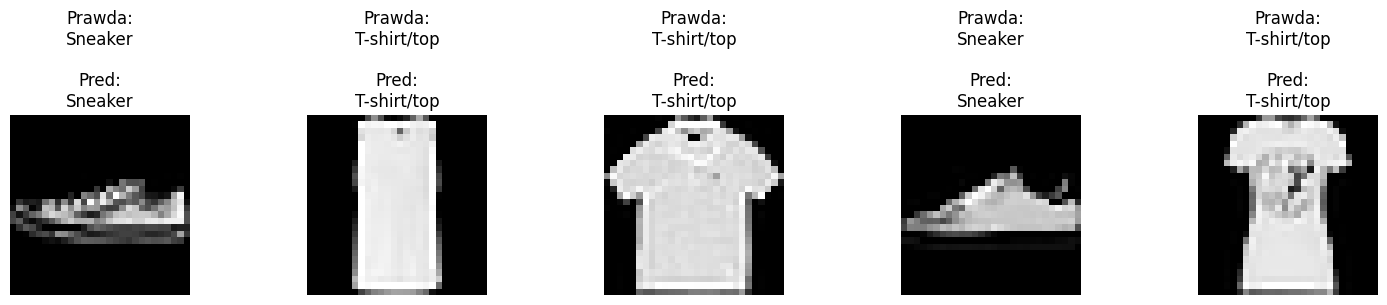

In [256]:
indices = random.sample(range(len(test_dataset)), 5)
# Tworzenie wykresu
plt.figure(figsize=(15, 3))

for i, idx in enumerate(indices):
    image, label = test_dataset[idx]
    input_image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_image)
        pred = output.argmax(dim=1).item()

    # Rysowanie obrazka
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Prawda:\n{class_names[label]}\n\nPred:\n{class_names[pred]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [257]:
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Konwersja do numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

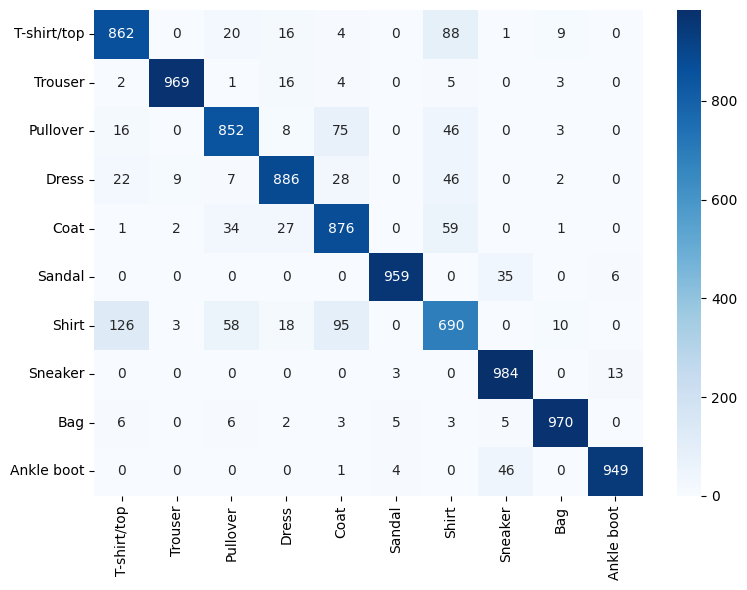

In [258]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.savefig('LSTM_CNN_matrix.png', dpi=300)
plt.show()


In [259]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(all_labels, all_preds)
print(f"MSE (LSTM_CNN): {mse:.4f}")

MSE (LSTM_CNN): 1.4308


In [260]:
train_probs, train_labels = get_probs_and_labels(train_loader)
test_probs, test_labels = get_probs_and_labels(test_loader)

ROC AUC dla klasy T-shirt/top: 0.9901
ROC AUC dla klasy Trouser: 0.9993
ROC AUC dla klasy Pullover: 0.9898
ROC AUC dla klasy Dress: 0.9952
ROC AUC dla klasy Coat: 0.9895
ROC AUC dla klasy Sandal: 0.9997
ROC AUC dla klasy Shirt: 0.9676
ROC AUC dla klasy Sneaker: 0.9990
ROC AUC dla klasy Bag: 0.9993
ROC AUC dla klasy Ankle boot: 0.9992


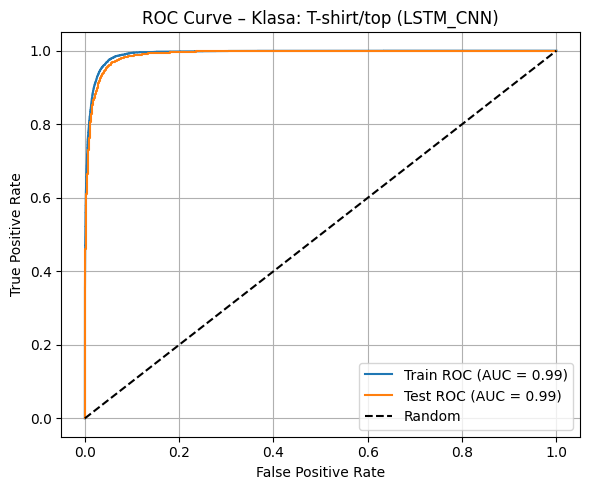

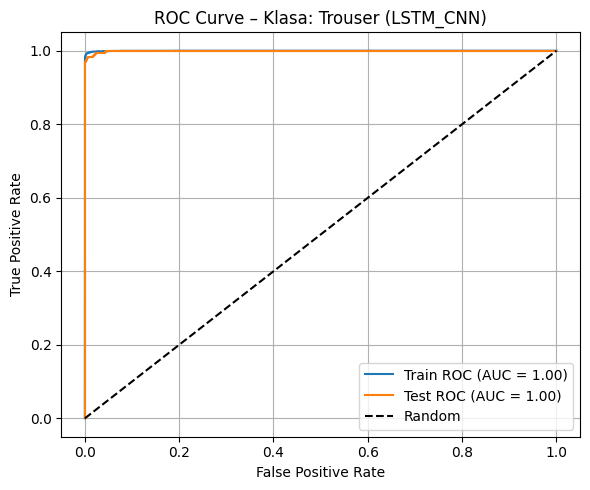

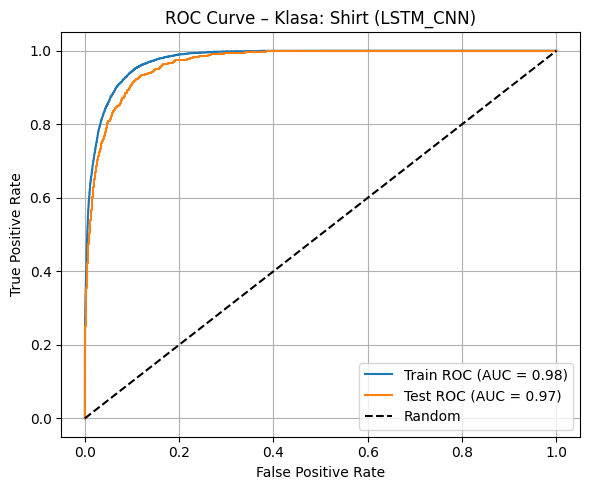

In [263]:
train_labels_bin = label_binarize(train_labels, classes=range(10))
test_labels_bin = label_binarize(test_labels, classes=range(10))
classes_to_plot = [0, 1, 6]  #T-shirt/top, Trouser, Shirt

roc_auc = roc_auc_score(labels_bin, all_probs, average=None) # 

for i, auc_val in enumerate(roc_auc):
    print(f"ROC AUC dla klasy {class_names[i]}: {auc_val:.4f}")

for i in classes_to_plot:
    # Train
    fpr_train, tpr_train, _ = roc_curve(train_labels_bin[:, i], train_probs[:, i])
    auc_train = auc(fpr_train, tpr_train)

    # Test
    fpr_test, tpr_test, _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    auc_test = auc(fpr_test, tpr_test)

    # Wykres
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.2f})")
    plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve – Klasa: {class_names[i]} (LSTM_CNN)")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Podsumownaie

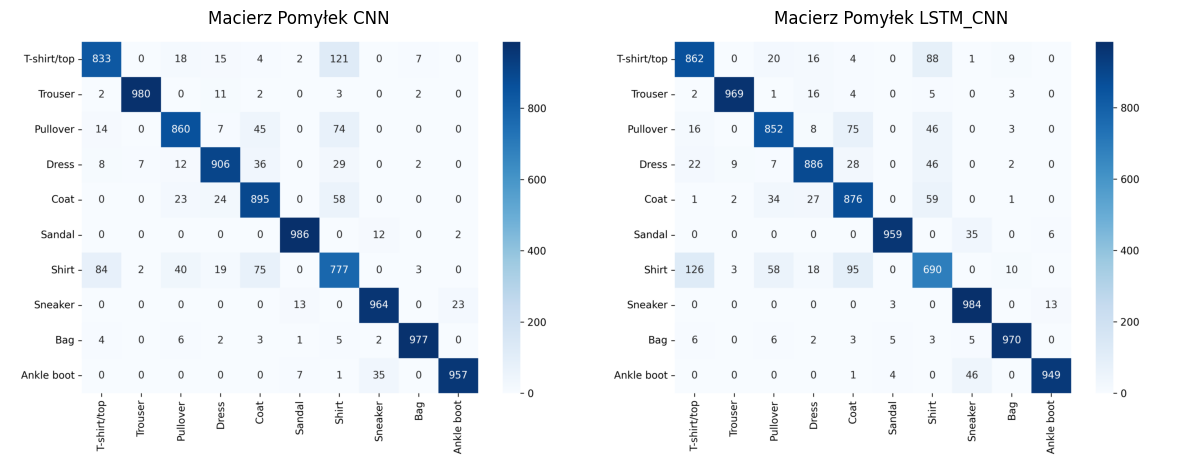

In [262]:
#wczytaj wykresy z plików
import matplotlib.image as mpimg
cnn_matrix = mpimg.imread("CNN_matrix.png")
lstm_cnn_matrix = mpimg.imread("LSTM_CNN_matrix.png")
#wyświetl wykresy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cnn_matrix)
plt.title("Macierz Pomyłek CNN")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(lstm_cnn_matrix)
plt.title("Macierz Pomyłek LSTM_CNN")
plt.axis('off')
plt.tight_layout()
plt.show()